# Diamanter

Jag har fått i uppdrag av ledningen på Guldfynd att analysera ett dataset från en diamantgrossist, innehållande relevanta priser och specifikationer för olika typer av diamanter. 

**Syftet** med analysen är att utvärdera potentiella investeringsmöjligheter för företaget, med fokus på att undersöka förutsättningarna för att inkludera diamantsmycken i vårt produktsortiment.

**Målet** är att tydligt identifiera strategi över vilka typer av diamanter som utgör de mest attraktiva investeringsalternativen, samt att kunna, genom att använda strategin, peka ut specifika exemplar i grossistens dataset som bedöms vara särskilt fördelaktiga att investera i just nu.

## Bakgrund

Diamanter är en av världens mest eftertraktade ädelstenar och används i allt från smycken till industriverktyg. Deras värde baseras inte bara på estetiska egenskaper, utan också på flera standardiserade kvalitetskriterier. För företag som överväger att investera i diamanter, exempelvis genom att inkludera diamantsmycken i sitt sortiment – är det avgörande att förstå vilka faktorer som styr prisbilden, hur marknaden fungerar och vilka risker och möjligheter som finns.

>### Fyra C:na, grunden för diamantvärdering:
>>**Carat** _(vikt)_: Ju högre vikt, desto mer sällsynt och värdefull är diamanten. Dock stiger priset inte enbart linjärt, små skillnader i carat kan ge stora prisvariationer.

>>**Cut** _(slipning)_: Slipningen avgör hur ljuset reflekteras i diamanten, vilket påverkar dess briljans och visuell kvalitet. <br>Normal ordning är: <br>Excellent,<br> Very Good,<br> Good,<br> Fair,<br> Poor<br><br> Men i datasettet representeras dessa annorlunda.<br><br>Excellent = Ideal,<br> Very Good = Premium,<br> Good = Very Good,<br> Fair = Good,<br> Poor = Fair

>>**Color** _(färg)_: I kontrast till informationen i det PDF-dokument jag tagit del av (diamonds_info), är de mest eftertraktade diamanterna de som är helt färglösa. Färg graderas enligt den internationella GIA-skalan från D (helt färglös) till Z (tydlig gul ton), där D representerar den högsta färgkvaliteten.

>>**Clarity** _(klarhet)_: Mått på inre och yttre defekter (inklusioner). Ju färre defekter, desto högre värde.

>#### Marknadsaspekter att beakta:
>>**Prisvariationer**: Två diamanter med liknande carat kan skilja kraftigt i pris beroende på färg, klarhet och slipning.

>>**Efterfrågemönster**: Konsumenter tenderar att föredra vissa specifikationer beroende på trender, kulturella preferenser och köpkraft.

## Analys

I analysen av datasettet kommer vi att gå igenom:  
1. Bortagning av felaktig data.  
2. Överblick över datasettet.  
3. Målgruppsspecifiering.  
4. Efterfrågan och företagsbild.  
5. Volatilitet.  
6. Investeringskategorier.  
7. Investeringsmöjligheter i det aktuella datasettet.  
8. Återkoppling till målet.

Jag kommer börja med att visa hur jag uteslöt felaktig data i datasettet.

#### 1. Bortagning av felaktig data

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

def clean_diamond_data(df):
    total_start = df.shape[0]
    removed = {}

    # Rensar ut nullvärden
    before = df.shape[0]
    df = df.dropna(subset=['index', 'cut', 'color', 'clarity', 'price', 'carat', 'x', 'y', 'z', 'depth'])
    removed["Saknade värden"] = before - df.shape[0]

    # Nollvärden i numeriska kolumner
    numeric_cols = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
    before = df.shape[0]
    for col in numeric_cols:
        df = df[df[col] > 0]
    removed["Nollvärden i numeriska kolumner"] = before - df.shape[0]

    # Extrema mått
    before = df.shape[0]
    df = df[(df['x'] <= 15) & (df['y'] <= 15) & (df['z'] <= 15)]
    removed["Extrema mått (>15 mm)"] = before - df.shape[0]

    # Oproportionerligt djup
    before = df.shape[0]
    df = df[~((df['carat'] < 1) & (df['z'] > 10))]
    removed["Misstänkt djup (carat < 1 & z > 10)"] = before - df.shape[0]

    # Depth-avvikelse
    df['depth_calc'] = (df['z'] / ((df['x'] + df['y']) / 2)) * 100
    df['depth_diff'] = abs(df['depth_calc'] - df['depth'])
    before = df.shape[0]
    df = df[df['depth_diff'] <= 1]
    removed[">1% avvikelse i depth"] = before - df.shape[0]

    # Sammanställning
    print("Sammanställning av borttagna rader:")
    for reason, quant in removed.items():
        print(f"- {reason}: {quant} rader")

    total_borttagna = total_start - df.shape[0]
    print(f"\nTotalt borttagna rader: {total_borttagna}")
    print(f"Rader kvar: {df.shape[0]}")

    return df


df = clean_diamond_data(pd.read_csv("diamonds.csv", sep=";"))

Sammanställning av borttagna rader:
- Saknade värden: 74 rader
- Nollvärden i numeriska kolumner: 22 rader
- Extrema mått (>15 mm): 3 rader
- Misstänkt djup (carat < 1 & z > 10): 0 rader
- >1% avvikelse i depth: 77 rader

Totalt borttagna rader: 176
Rader kvar: 53764


**Jag har utvecklat en funktion som rengör datasettet genom att stegvis filtrera bort diamanter som:**  
1. Saknar nödvändiga värden  
2. Har nollvärden i fysiska mått (x, y, z)  
3. Uppvisar extrema dimensioner (över 15 mm)  
4. Har oproportionerligt stort djup i förhållande till sin vikt (carat < 1 och z > 10 mm)  
Uppvisar en avvikelse på mer än 1 % mellan angivet djup och det geometriskt beräknade djupet  

Syftet med denna funktion är att säkerställa att den fortsatta analysen baseras på ett så korrekt och tillförlitligt underlag som möjligt.

### 2. Överblick över datasettet

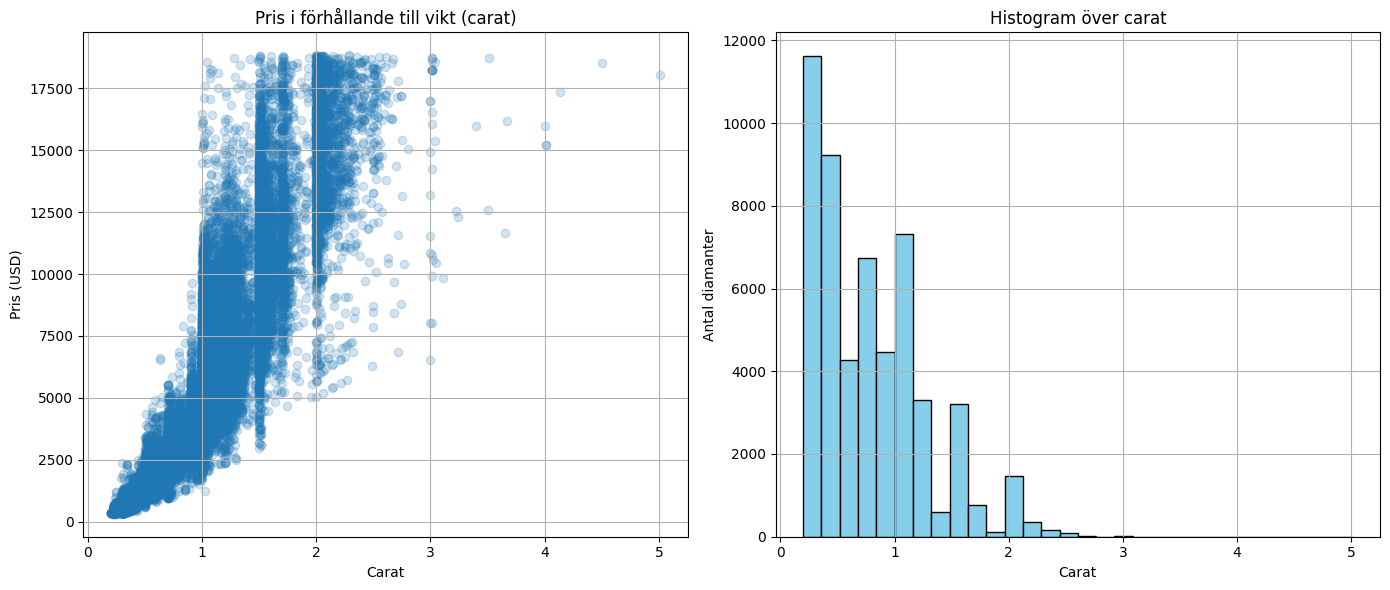

Korrelationen mellan carat och pris är: 0.92


In [117]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].scatter(df['carat'], df['price'], alpha=0.2)
ax[0].set_title('Pris i förhållande till vikt (carat)')
ax[0].set_xlabel('Carat')
ax[0].set_ylabel('Pris (USD)')
ax[0].grid(True)

ax[1].hist(df['carat'], bins=30, color='skyblue', edgecolor='black')
ax[1].set_title('Histogram över carat')
ax[1].set_xlabel('Carat')
ax[1].set_ylabel('Antal diamanter')
ax[1].grid(True)

plt.tight_layout()
plt.show()
correlation = df['carat'].corr(df['price'])
print(f'Korrelationen mellan carat och pris är: {correlation:.2f}')

I de två översiktsdiagrammen framgår det att majoriteten av diamanterna väger under 1 carat, och att priset har en korrelation på 0.92 med caratvärdet.

Vi kan även se att vid vissa specifika viktgränser, såsom 1.0, 1.5 och 2.0 carat, tenderar priserna att vara både högre och mer utspridda jämfört med närliggande caratnivåer. Detta tyder på att dessa caratgränser har ett särskilt marknadsvärde eller efterfrågemönster.

### 3. Målgruppsspecifiering

Efter en marknadsanalys framgår det att diamanter under 1.0 carat är vanligast förekommande i smyckesproduktion.

I Norden präglas efterfrågan av mer återhållsamma preferenser, vigselringar innehåller vanligtvis stenar på mellan 0.3 och 1.0 carat, medan andra smycken som örhängen, halsband och armband ofta använder ännu mindre diamanter.

I kontrast till detta ser vi i datan att diamanter på 1.0, 1.5 och 2.0 carat är betydligt vanligare i exempelvis den amerikanska marknaden, där större stenar ofta förekommer i vigselringar.

Diamanter över 2.5 carat är relativt ovanliga inom traditionell smyckesdesign och återfinns främst i investeringssyfte.

Mot denna bakgrund rekommenderas att vi på Guldfynd fokuserar på diamanter i spannet 0.1–1.0 carat. Detta kommer att medföra nackdelen att Guldfynd inte erbjuda extremt unika och exsklusiva diamater, tex en diamant på 3 karat. Men målgruppen vi har i nordiska länder stärker bilden av att 0.1-1.0 är det karat spanned vi bör lägga fokus på.  

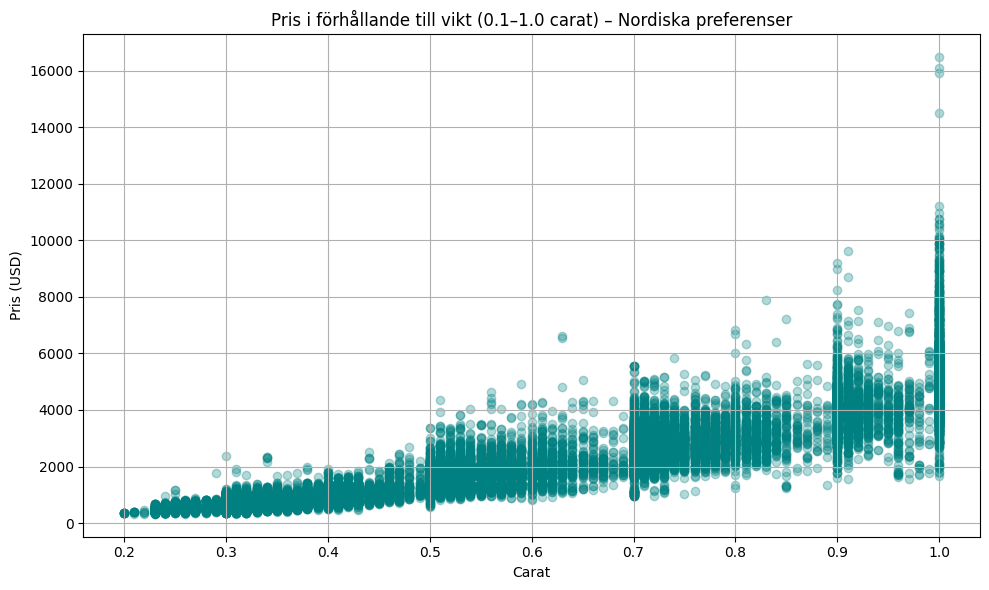

In [26]:
nordic_df = df[(df['carat'] >= 0.1) & (df['carat'] <= 1.0)]

plt.figure(figsize=(10, 6))
plt.scatter(nordic_df['carat'], nordic_df['price'], alpha=0.3, color='teal')
plt.title('Pris i förhållande till vikt (0.1–1.0 carat) – Nordiska preferenser')
plt.xlabel('Carat')
plt.ylabel('Pris (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

*Detta diagram visar alla diamanter som är under 1 carat i datasettet.*

### 4. Efterfrågan och företagsbild

Diamanter med synliga inneslutningar eller missfärgningar uppfattas generellt som mindre exklusiva och kan påverka kundens upplevelse negativt. Det visuella spelar stor roll för en kund, alltså clarity, vilket motsvarar klarheten i diamanten, color vilket är färgen med ofärgad som högst eftertraktad (D). Cut som motsvarar slipningen är däremot inte lika synligt för kunden eftersom det påverkar endast reflektionen i diamanten.   

För att upprätthålla Guldfynds position som en kvalitetsleverantör bör vi undvika att inkludera stenar som upplevs som smutsiga, suddiga eller färgförändrade.

Jag rekommenderar därför att vi enbart investerar i diamanter med hög klarhet (clarity), så låg färggrad som möjligt samt god slipning (cut). Detta säkerställer att våra smycken håller en hög visuell standard och stärker kundens förtroende för varumärket.

Eftersom både datamängden och omvärldsanalysen visar att det finns ett stort utbud av diamanter inom det aktuella spannet, krävs en tydlig strategi för att identifiera de alternativ där företaget har möjlighet att uppnå god lönsamhet.

Därför kommer vi nu att undersöka prisvolatiliteten inom detta segment med clarity, färg och cut i åtanke, för att identifiera var de mest gynnsamma investeringsmöjligheterna finns.

### 5. Volatilitet

>#### Volatiliteten grupperat i color

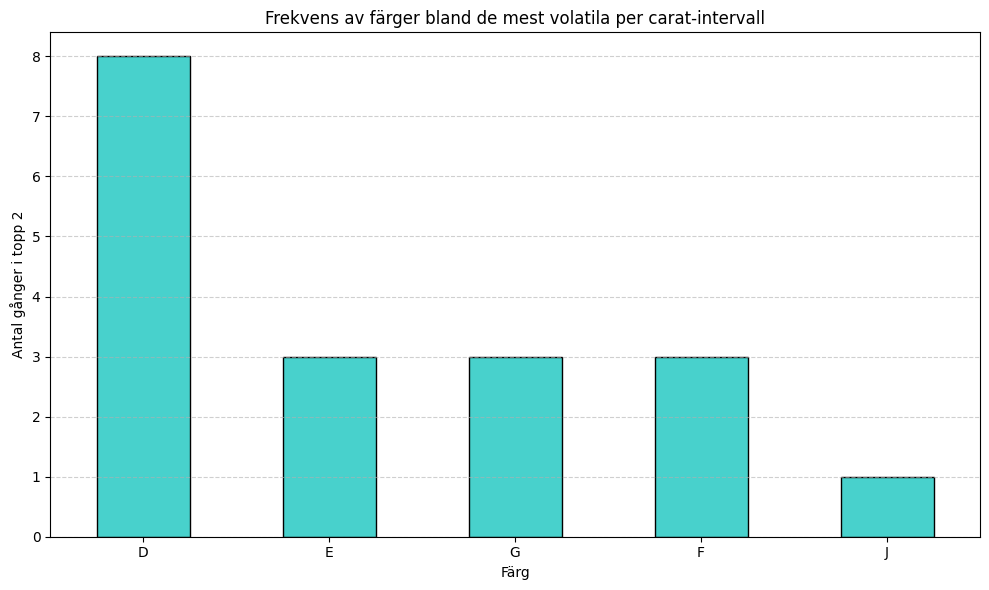

Topp 2 vanligaste färger bland mest volatila per carat-intervall:
color
D    8
E    3
Name: count, dtype: int64


In [108]:
nordic_df = nordic_df.copy()

nordic_df['carat_bin'] = pd.cut(nordic_df['carat'], bins=np.arange(0.1, 1.05, 0.1))

volatility = nordic_df.groupby(['carat_bin', 'color'], observed=False)['price'].agg(['mean', 'std', 'min', 'max'])
volatility['variation'] = volatility['std'] / volatility['mean']
volatility = volatility.dropna()
volatility_sorted = volatility.sort_values(by=['carat_bin', 'variation'], ascending=[True, False])

top2_per_bin = volatility_sorted.groupby(level='carat_bin', observed=True).head(2)

color_frekvens = top2_per_bin.reset_index()['color'].value_counts()

topp2_färger = color_frekvens.head(2)
# Räkna hur ofta varje färg förekommer i top2_per_bin
all_colors = top2_per_bin.reset_index()['color'].value_counts()

# Skapa stapeldiagram för alla färger
plt.figure(figsize=(10, 6))
all_colors.plot(kind='bar', color='mediumturquoise', edgecolor='black')

plt.title('Frekvens av färger bland de mest volatila per carat-intervall')
plt.xlabel('Färg')
plt.ylabel('Antal gånger i topp 2')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
print("Topp 2 vanligaste färger bland mest volatila per carat-intervall:")
print(topp2_färger)



>#### Volatiliteten grupperat i clarity

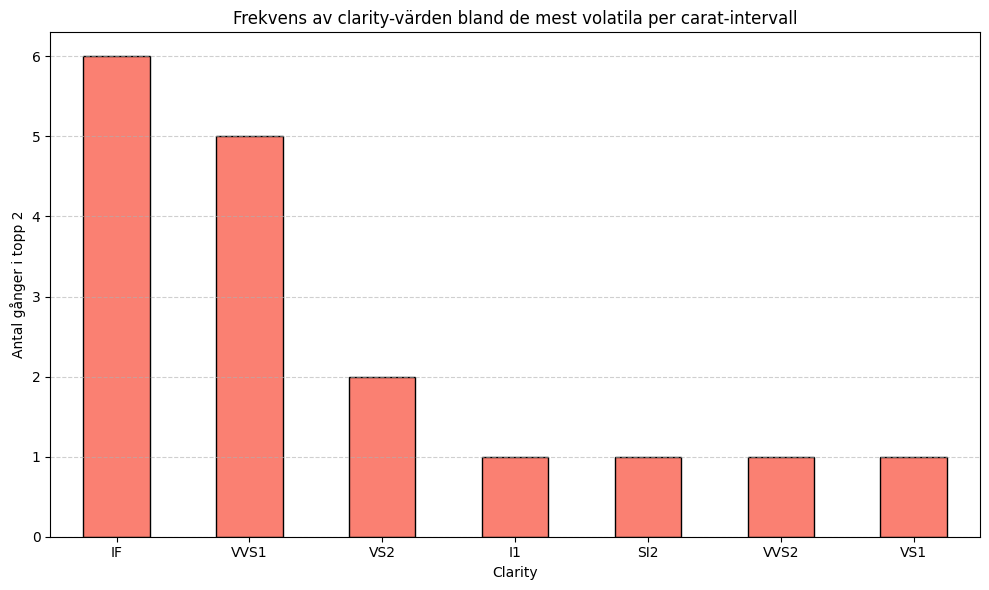

Topp 2 vanligaste clarity-värden bland mest volatila per carat-intervall:
clarity
IF      6
VVS1    5
Name: count, dtype: int64


In [110]:
nordic_df = nordic_df.copy()

if 'carat_bin' not in nordic_df.columns:
    nordic_df['carat_bin'] = pd.cut(nordic_df['carat'], bins=np.arange(0.1, 1.05, 0.1))

clarity_volatility = nordic_df.groupby(['carat_bin', 'clarity'], observed=False)['price'].agg(['mean', 'std', 'min', 'max'])
clarity_volatility['variation'] = clarity_volatility['std'] / clarity_volatility['mean']
clarity_volatility = clarity_volatility.dropna()

clarity_sorted = clarity_volatility.sort_values(by=['carat_bin', 'variation'], ascending=[True, False])

top2_per_bin_clarity = clarity_sorted.groupby(level='carat_bin', observed=True).head(2)

clarity_frekvens = top2_per_bin_clarity.reset_index()['clarity'].value_counts()

topp2_clarity = clarity_frekvens.head(2)
# Räkna hur ofta varje clarity förekommer i top2_per_bin_clarity
all_clarities = top2_per_bin_clarity.reset_index()['clarity'].value_counts()

# Skapa stapeldiagram
plt.figure(figsize=(10, 6))
all_clarities.plot(kind='bar', color='salmon', edgecolor='black')

plt.title('Frekvens av clarity-värden bland de mest volatila per carat-intervall')
plt.xlabel('Clarity')
plt.ylabel('Antal gånger i topp 2')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
print("Topp 2 vanligaste clarity-värden bland mest volatila per carat-intervall:")
print(topp2_clarity)

>#### Volatiliteten grupperat i cut

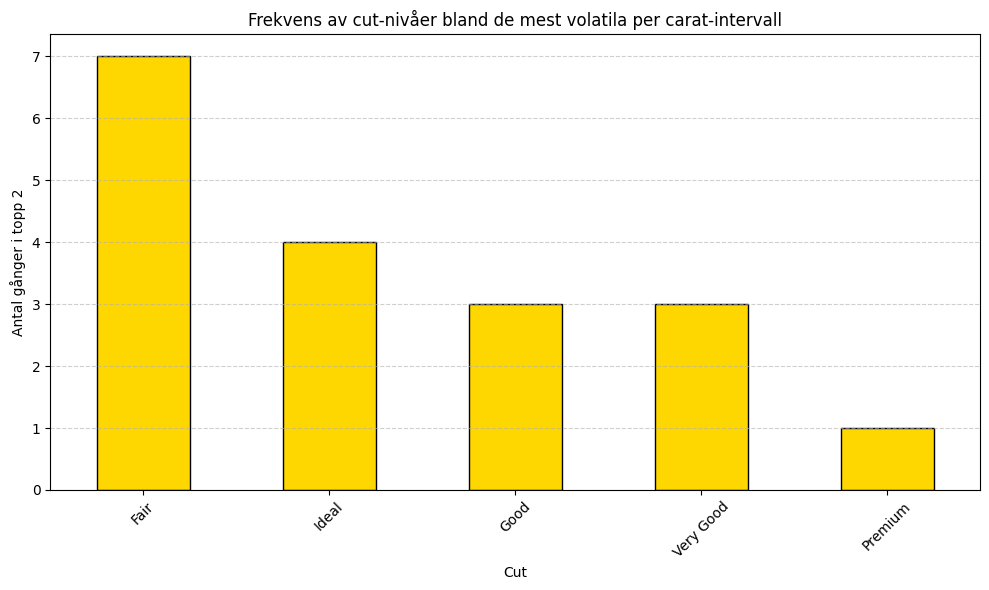

Topp 2 vanligaste cut-nivåer bland mest volatila per carat-intervall:
cut
Fair     7
Ideal    4
Name: count, dtype: int64


In [112]:
nordic_df = nordic_df.copy()

if 'carat_bin' not in nordic_df.columns:
    nordic_df['carat_bin'] = pd.cut(nordic_df['carat'], bins=np.arange(0.1, 1.05, 0.1))

cut_volatility = nordic_df.groupby(['carat_bin', 'cut'], observed=False)['price'].agg(['mean', 'std', 'min', 'max'])
cut_volatility['variation'] = cut_volatility['std'] / cut_volatility['mean']
cut_volatility = cut_volatility.dropna()

cut_sorted = cut_volatility.sort_values(by=['carat_bin', 'variation'], ascending=[True, False])

top2_per_bin_cut = cut_sorted.groupby(level='carat_bin', observed=True).head(2)

cut_frekvens = top2_per_bin_cut.reset_index()['cut'].value_counts()

topp2_cut = cut_frekvens.head(2)
# Räkna hur ofta varje cut förekommer i top2_per_bin_cut
all_cuts = top2_per_bin_cut.reset_index()['cut'].value_counts()

# Skapa stapeldiagram
plt.figure(figsize=(10, 6))
all_cuts.plot(kind='bar', color='gold', edgecolor='black')

plt.title('Frekvens av cut-nivåer bland de mest volatila per carat-intervall')
plt.xlabel('Cut')
plt.ylabel('Antal gånger i topp 2')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
print("Topp 2 vanligaste cut-nivåer bland mest volatila per carat-intervall:")
print(topp2_cut)

### 6. Investeringskategorier

Baserat på beräkningarna ovan framgår det att diamanter med vissa specifika attribut uppvisar olika grad av prisvolatilitet.

En diamant med egenskaperna

Color: D

Clarity: IF

Cut: Fair

uppvisar den högst volatiliteten i pris.

In [125]:
filtered = nordic_df[
    (nordic_df['color'].isin(['D', 'E'])) &
    (nordic_df['clarity'].isin(['IF', 'VVS2']))
]

kombinationer = filtered.groupby(['color', 'clarity', 'cut']).size().reset_index(name='antal')
print(kombinationer)

   color clarity        cut  antal
0      D      IF       Fair      3
1      D      IF       Good      5
2      D      IF      Ideal     22
3      D      IF    Premium      5
4      D      IF  Very Good     13
5      D    VVS2       Fair      8
6      D    VVS2       Good     23
7      D    VVS2      Ideal    233
8      D    VVS2    Premium     75
9      D    VVS2  Very Good    128
10     E      IF       Good      9
11     E      IF      Ideal     67
12     E      IF    Premium     19
13     E      IF  Very Good     34
14     E    VVS2       Fair     13
15     E    VVS2       Good     43
16     E    VVS2      Ideal    446
17     E    VVS2    Premium    105
18     E    VVS2  Very Good    277


Genom att ta de två högsta volatilitetsgrupperna inom color och clarity från uträkningen kan vi sammanställa att en diamant med någon av kombinationerna ovan har högre volatilitet än andra kombinationer i datasettet.
Detta öppnar upp möjligheter för oss på Guldfynd att göra strategiska inköp till lägre prisnivåer och därefter sälja med god marginal.

Samtidigt ligger color och clarity högt i sina respektive kvalitetsskalor, vilket sammanstrålar med bilden av Guldfynd som en leverantör av exklusiva och eftertraktade smycken. Eftersom uträkningen av de två högsta volatilitetsgrupper inom kategorin cut visar, Fair(vilket är den lägsta) och Ideal(vilket är den högsta) stämmer detta också in med omvärldsanalysen, där den inte har samma betydelse för kunden. Detta innebär att vi kan utesluta cut från att ha en betydande roll i våra investeringsmöjligheter.

### 7. Investeringsmöjligheter i det aktuella datasettet

In [60]:
def cheap_diamonds_by_carat(df, group_columns, price_column="price", carat_column="carat"):
    df = df[df[carat_column] <= 1.0].copy()

    result = []
    groups = df.groupby(group_columns)

    for name, group in groups:
        group = group.copy()
        group['carat_round'] = (group[carat_column] * 10).round() / 10

        for carat_val, sub_group in group.groupby('carat_round'):
            if len(sub_group) < 10:
                continue

            median_price = sub_group[price_column].median()
            cheap = sub_group[sub_group[price_column] < median_price].copy()
            cheap["kategori"] = f"{name[0]},{name[1]},{name[2]}"
            cheap["med_price"] = median_price
            cheap["un_med_usd"] = (median_price - cheap[price_column]).round(2)
            cheap["un_med_percent"] = ((median_price - cheap[price_column]) / median_price * 100).round(1)
            result.append(cheap)

    if result:
        return pd.concat(result, ignore_index=True)
    else:
        return pd.DataFrame()
cheap = cheap_diamonds_by_carat(filtered, ['color', 'clarity', 'cut'])

cheap = cheap.sort_values(by="un_med_usd", ascending=False)

top50 = cheap[['index','price','med_price', 'un_med_usd', 'un_med_percent', 'kategori']].head(50)
print(top50)

     index   price  med_price  un_med_usd  un_med_percent          kategori
103   1783  3049.0     4369.0      1320.0            30.2      D,VVS2,Ideal
104   2011  3103.0     4369.0      1266.0            29.0      D,VVS2,Ideal
448   1984  3093.0     3990.0       897.0            22.5      E,VVS2,Ideal
98   51833  2421.0     3282.0       861.0            26.2      D,VVS2,Ideal
449   2672  3238.0     3990.0       752.0            18.8      E,VVS2,Ideal
99   53085  2612.0     3282.0       670.0            20.4      D,VVS2,Ideal
100  53120  2617.0     3282.0       665.0            20.3      D,VVS2,Ideal
101  53247  2644.0     3282.0       638.0            19.4      D,VVS2,Ideal
407  45230  1657.0     2292.5       635.5            27.7      E,VVS2,Ideal
105   4981  3737.0     4369.0       632.0            14.5      D,VVS2,Ideal
102  53720  2720.0     3282.0       562.0            17.1      D,VVS2,Ideal
408  46070  1736.0     2292.5       556.5            24.3      E,VVS2,Ideal
106   5542  

Funktionen ovan fokuserar på diamanter under 1.0 carat, i linje med företagets målgrupp, och grupperar därefter datan utifrån kombinationer av kvalitetskriterier. Inom varje grupp där det finns mer än 10 diamanter jämförs diamanternas pris med medianpriset i samma caratintervall. De som är billigare än medianen lyfts fram som potentiellt prisvärda.

Resultatet sorteras sedan utifrån hur mycket priset avviker nedåt i dollar från medianen, vilket gör det möjligt att snabbt identifiera de mest attraktiva köptillfällena utifrån företagets kravspecifikation. Vid behov kan vi sortera efter procenten jämfört med medianen, för att få en snabb överblick över pontentiell rea.

Nu kommer jag visa en överblick igen där de top 50 bästa investeringsmöjlighetern i datasettet finns.

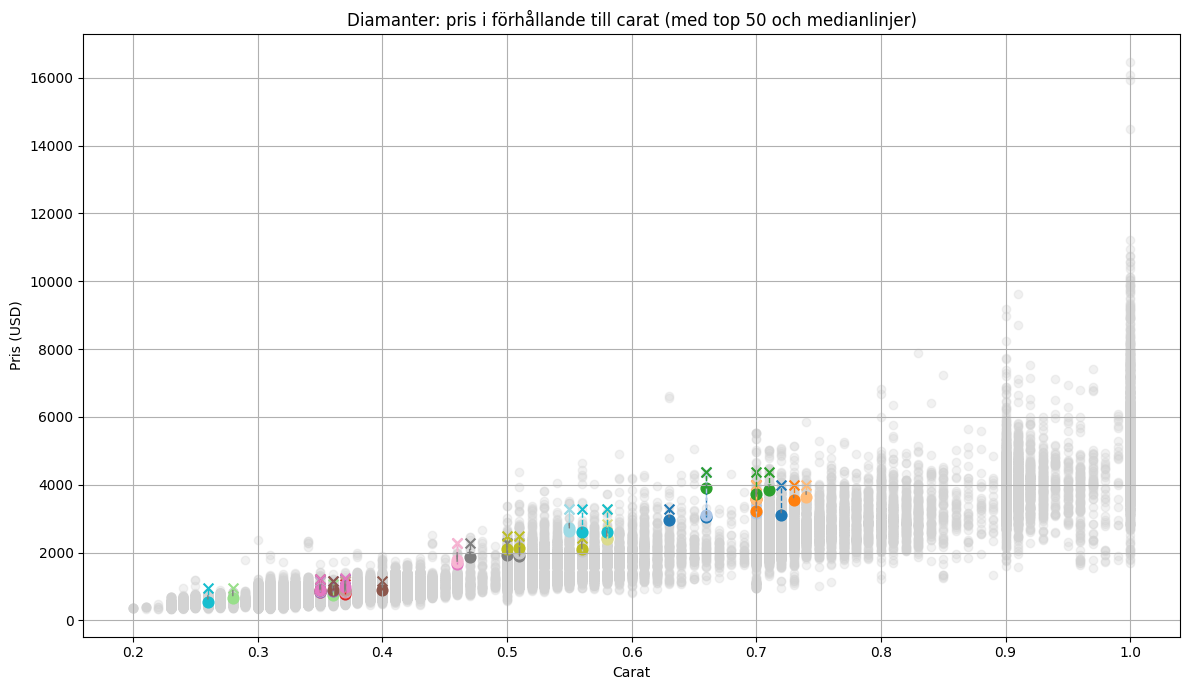

ID 51978: E,IF,Very Good – 547.0 USD (−42.6% mot median)
ID 27364: E,VVS2,Premium – 646.0 USD (−32.0% mot median)
ID 30785: E,VVS2,Very Good – 742.0 USD (−30.7% mot median)
ID 1783: D,VVS2,Ideal – 3049.0 USD (−30.2% mot median)
ID 34257: D,VVS2,Ideal – 857.0 USD (−29.2% mot median)
ID 2011: D,VVS2,Ideal – 3103.0 USD (−29.0% mot median)
ID 33925: E,VVS2,Ideal – 844.0 USD (−28.2% mot median)
ID 33926: E,VVS2,Ideal – 844.0 USD (−28.2% mot median)
ID 33659: D,VVS2,Very Good – 835.0 USD (−28.1% mot median)
ID 34022: E,VVS2,Ideal – 849.0 USD (−27.8% mot median)
ID 34021: E,VVS2,Ideal – 849.0 USD (−27.8% mot median)
ID 45230: E,VVS2,Ideal – 1657.0 USD (−27.7% mot median)
ID 32047: E,VVS2,Very Good – 779.0 USD (−27.2% mot median)
ID 34998: D,VVS2,Ideal – 882.0 USD (−27.1% mot median)
ID 51833: D,VVS2,Ideal – 2421.0 USD (−26.2% mot median)
ID 34681: E,VVS2,Ideal – 873.0 USD (−25.8% mot median)
ID 34743: E,VVS2,Ideal – 876.0 USD (−25.5% mot median)
ID 34993: E,VVS2,Ideal – 881.0 USD (−25.1% mot 

In [63]:

cmap = plt.colormaps.get_cmap('tab20')
colors = [cmap(i / 50) for i in range(50)]


top50_full = nordic_df[['index', 'carat', 'price']].merge(
    top50[['index', 'med_price', 'un_med_percent', 'kategori']], on='index', how='inner'
)

plt.figure(figsize=(12, 7))
plt.scatter(nordic_df['carat'], nordic_df['price'], alpha=0.3, color='lightgray', label='Alla diamanter')


for i, (_, row) in enumerate(top50_full.iterrows()):
    color = colors[i]
    carat = row['carat']
    price = row['price']
    median_price = row['med_price']
    idx = int(row['index'])

    plt.plot([carat, carat], [price, median_price], color=color, linestyle='--', linewidth=1)
    plt.scatter(carat, price, color=color, s=60)
    plt.scatter(carat, median_price, color=color, marker='x', s=50)

    plt.annotate(
        text=str(),
        xy=(carat, price),
        xytext=(carat, price + 250 + np.random.uniform(-100, 100)),
        arrowprops=dict(arrowstyle='-', color='gray'),
        fontsize=8,
        color='black',
        ha='center'
    )

plt.title('Diamanter: pris i förhållande till carat (med top 50 och medianlinjer)')
plt.xlabel('Carat')
plt.ylabel('Pris (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

sorted_top50 = top50.sort_values(by='un_med_percent', ascending=False)

# Skriva ut listan
for _, row in sorted_top50.iterrows():
    print(f"ID {int(row['index'])}: {row['kategori']} – {row['price']} USD (−{row['un_med_percent']}% mot median)")

### Vinst i datasettet

In [65]:
top50_diamonds = top50.copy()

top50_diamonds['med_price'] = top50_diamonds['price'] + top50_diamonds['un_med_usd']
top50_diamonds['med_price_10pct'] = top50_diamonds['med_price'] * 1.10

top50_diamonds['vinst_median'] = top50_diamonds['med_price'] - top50_diamonds['price']
top50_diamonds['vinst_10pct'] = top50_diamonds['med_price_10pct'] - top50_diamonds['price']

total_investering = top50_diamonds['price'].sum()
total_vinst_median = top50_diamonds['vinst_median'].sum()
total_vinst_10pct = top50_diamonds['vinst_10pct'].sum()

print(f"Total investering (inköpspris för 50 diamanter): ${total_investering:,.2f}")
print(f"Total möjlig vinst vid försäljning till medianpris: ${total_vinst_median:,.2f}")
print(f"Total möjlig vinst vid försäljning till +10% över median: ${total_vinst_10pct:,.2f}")

Total investering (inköpspris för 50 diamanter): $97,860.00
Total möjlig vinst vid försäljning till medianpris: $22,846.50
Total möjlig vinst vid försäljning till +10% över median: $34,917.15


Vi kan se att genom att använda denna strategi i datasettet och investera i de 50 mest attraktiva diamanterna, kan vi göra en vinst på 22,846.50 USD om vi säljer till medianpriset för respektive diamants kategori.  
Säljer vi över medianen med 10% vilket är möjligt eftersom volatiliteten i dessa kategorier är hög kan vinsten uppgå till 34,917.15 USD.
Att notera är även att detta är enbart diamanterna, om vi på Guldfynd implementerar dem i eftertraktade smycken så kan vi även räkna med vinsten från till exempel arbetet och de andra ädelmetallerna som smycket innefattar.

En nackdel vi kan se i just detta datasettet är att vi inte kommer att inneha några diamanter som är större än 0.75 karat. Men med tiden med tillgång till fler grossister och dataset så kommer vi kunna använda samma strategi för att skaffa den storleken vi vill ha. I just detta datasettet finns tex diamanter som ligger under medianen i sin grupp och är exakt 1 karat. Men det är inte tillräckligt många(alltså över 10st) för att vi ska kunna dra slutsatsen att vi kan med säkerhet sälja till median priset och därmed gå med vinst.

### 8. Återkoppling till målet.

Syftet med analysen har varit att tydligt definiera en strategi för att identifiera de mest attraktiva investeringsalternativen. Genom att kombinera kvalitetskriterier med prisanalys och volatilitetsbedömning har vi kunnat ringa in både vilka typer av diamanter som är särskilt lönsamma att investera i, och även identifiera enskilda exemplar i datasettet som matchar denna strategi.

Resultatet möjliggör ett datadrivet beslutsunderlag som kan användas för både sortimentsutveckling och inköpsstrategi – i linje med Guldfynds ambition att erbjuda hög kvalitet till konkurrenskraftigt pris

## Executive Summary

Denna analys genomfördes på uppdrag av ledningen för att utvärdera möjligheterna att inkludera diamanter i Guldfynds produktsortiment. Genom att analysera ett omfattande dataset från en grossist har det identifierats vilka diamanttyper som är mest attraktiva utifrån ett investeringsperspektiv.

Analysen visar att diamanter under 1.0 carat, särskilt med höga värden inom clarity och color är både efterfrågade och ekonomiskt fördelaktiga. Jag har utvecklat en strategi för att identifiera specifika exemplar som säljs under medianpris inom respektive kvalitetskategori, vilket möjliggör god marginal vid återförsäljning.

Jag rekommenderar att Guldfynd fokuserar på investeringar i diamanter mellan 0.1 och 1.0 carat med clarity och color högt i skalan, då dessa bäst matchar kundernas preferenser i Norden och samtidigt erbjuder hög visuell kvalitet och affärspotential.